# Exercises

In this section we have two exercises:
1. Implement the polynomial kernel.
2. Implement the multiclass C-SVM.

## Polynomial kernel

You need to extend the ``build_kernel`` function and implement the polynomial kernel if the ``kernel_type`` is set to 'poly'. The equation that needs to be implemented:
\begin{equation}
K=(X^{T}*Y)^{d}.
\end{equation}

In [1]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.model_selection import train_test_split
import cvxopt

iris = load_iris()
data_set = iris.data
labels = iris.target

data_set = data_set[labels!=2]
labels = labels[labels!=2]

train_data_set, test_data_set, train_labels, test_labels = train_test_split(
    data_set, labels, test_size=0.2, random_state=15)

train_labels[train_labels<1] = -1
test_labels[test_labels<1] = -1

objects_count = len(train_labels)

In [2]:
def build_kernel(data_set, kernel_type='linear', Y = [1, 1], d = 2):
    kernel = np.dot(data_set, data_set.T)
    
    if kernel_type == 'rbf':
        sigma = 1.0
        objects_count = len(data_set)
        b = np.ones((len(data_set), 1))
        kernel -= 0.5 * (np.dot((np.diag(kernel)*np.ones((1, objects_count))).T, b.T)
                         + np.dot(b, (np.diag(kernel) * np.ones((1, objects_count))).T.T))
        kernel = np.exp(kernel / (2. * sigma ** 2))
    
    elif kernel_type == 'poly':       
        if len(Y) != len(data_set):
            n = len(data_set)
            Y = np.eye(n)
            
        kernel = np.power(np.dot (np.dot(data_set, data_set.T), Y.T ), d )
    return kernel



In [3]:
Y = np.ones(shape = [1, 100])   # sample Y
d = 2                           # sample d


linear_kernel = build_kernel(train_data_set, kernel_type = 'poly', Y = Y, d = 1)
linear_kernel

array([[58.83, 41.31, 47.53, ..., 49.19, 41.63, 64.95],
       [41.31, 33.06, 37.97, ..., 39.56, 33.5 , 44.38],
       [47.53, 37.97, 43.65, ..., 45.39, 38.52, 51.15],
       ...,
       [49.19, 39.56, 45.39, ..., 47.42, 40.04, 52.7 ],
       [41.63, 33.5 , 38.52, ..., 40.04, 34.01, 44.75],
       [64.95, 44.38, 51.15, ..., 52.7 , 44.75, 72.2 ]])

## Implement a multiclass C-SVM

Use the classification method that we used in notebook 7.3 and IRIS dataset to build a multiclass C-SVM classifier. Most implementation is about a function that will return the proper data set that need to be used for the prediction. You need to implement:
- ``choose_set_for_label``
- ``get_labels_count``

In [4]:
import seaborn as sns
%matplotlib inline
from sklearn.metrics import accuracy_score

In [5]:
def choose_set_for_label(train_labels, test_labels, treshold = 1):
    
    train_labels[train_labels< treshold] = -1
    test_labels[test_labels< treshold] = -1

    train_labels[train_labels >= treshold] = 1
    test_labels[test_labels >= treshold] = 1
    
    return train_labels, test_labels 

In [6]:
def get_labels_count(data_set):
    return labels_count

The code from 7.3 notebook

In [7]:
def train(train_data_set, train_labels, kernel_type='linear', C=10, threshold=1e-5):
    kernel = build_kernel(train_data_set, kernel_type=kernel_type)

    P = train_labels * train_labels.transpose() * kernel
    q = -np.ones((objects_count, 1))
    G = np.concatenate((np.eye(objects_count), -np.eye(objects_count)))
    h = np.concatenate((C * np.ones((objects_count, 1)), np.zeros((objects_count, 1))))

    A = train_labels.reshape(1, objects_count)
    A = A.astype(float)
    b = 0.0

    sol = cvxopt.solvers.qp(cvxopt.matrix(P), cvxopt.matrix(q), cvxopt.matrix(G), cvxopt.matrix(h), cvxopt.matrix(A), cvxopt.matrix(b))

    lambdas = np.array(sol['x'])

    support_vectors_id = np.where(lambdas > threshold)[0]
    vector_number = len(support_vectors_id)
    support_vectors = train_data_set[support_vectors_id, :]

    lambdas = lambdas[support_vectors_id]
    targets = train_labels[support_vectors_id]

    b = np.sum(targets)
    for n in range(vector_number):
        b -= np.sum(lambdas * targets * np.reshape(kernel[support_vectors_id[n], support_vectors_id], (vector_number, 1)))
    b /= len(lambdas)

    return lambdas, support_vectors, support_vectors_id, b, targets, vector_number

In [8]:
def build_kernel(data_set, kernel_type='linear'):
    kernel = np.dot(data_set, data_set.T)
    if kernel_type == 'rbf':
        sigma = 1.0
        objects_count = len(data_set)
        b = np.ones((len(data_set), 1))
        kernel -= 0.5 * (np.dot((np.diag(kernel)*np.ones((1, objects_count))).T, b.T)
                         + np.dot(b, (np.diag(kernel) * np.ones((1, objects_count))).T.T))
        kernel = np.exp(kernel / (2. * sigma ** 2))
    return kernel

In [9]:
def classify_rbf(test_data_set, train_data_set, lambdas, targets, b, vector_number, support_vectors, support_vectors_id):
    kernel = np.dot(test_data_set, support_vectors.T)
    sigma = 1.0
    c = (1. / sigma * np.sum(test_data_set ** 2, axis=1) * np.ones((1, np.shape(test_data_set)[0]))).T
    c = np.dot(c, np.ones((1, np.shape(kernel)[1])))
    sv = (np.diag(np.dot(train_data_set, train_data_set.T))*np.ones((1,len(train_data_set)))).T[support_vectors_id]
    aa = np.dot(sv,np.ones((1,np.shape(kernel)[0]))).T
    kernel = kernel - 0.5 * c - 0.5 * aa
    kernel = np.exp(kernel / (2. * sigma ** 2))

    y = np.zeros((np.shape(test_data_set)[0], 1))
    for j in range(np.shape(test_data_set)[0]):
        for i in range(vector_number):
            y[j] += lambdas[i] * targets[i] * kernel[j, i]
        y[j] += b
    return np.sign(y)

## START

In [10]:
iris = load_iris()
data_set = iris.data
labels = iris.target

train_data_set, test_data_set, train_labels, test_labels = train_test_split(
    data_set, labels, test_size=0.2, random_state=15)

/home/neofelia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


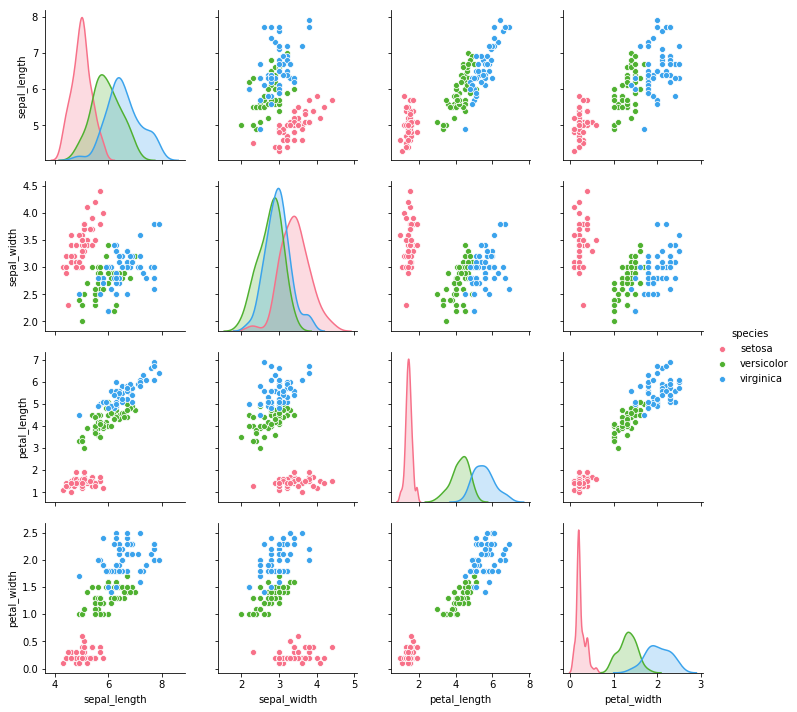

In [11]:
iris = sns.load_dataset("iris")
sns.pairplot(iris, hue="species", palette = 'husl');

Based on the above figure, the best strategy for multiclass C-SVM classification is 'one versus all'. First setosa vs all, second versicolor vs virginica.

In [12]:
# Divide setosa vs all the rest:

train_data_set_1 = np.copy(train_data_set)
test_data_set_1 = np.copy(test_data_set)

train_labels_1 = np.copy(train_labels)
test_labels_1 = np.copy(test_labels)

train_labels_1, test_labels_1 = choose_set_for_label(train_labels_1, test_labels_1, treshold = 1)

objects_count = len(train_data_set)
lambdas, support_vectors, support_vectors_id, b, targets, vector_number = train(train_data_set_1, train_labels_1, kernel_type='rbf')

predicted = classify_rbf(test_data_set, train_data_set, lambdas, targets, b, vector_number, support_vectors, support_vectors_id)
predicted = list(predicted.astype(int))

print("\nAccuracy:\t", accuracy_score(predicted, test_labels_1))

     pcost       dcost       gap    pres   dres
 0:  1.1726e+02 -1.7992e+03  4e+03  2e-01  2e-15
 1:  7.7967e+01 -1.6973e+02  3e+02  5e-03  2e-15
 2:  1.0169e+01 -2.2323e+01  3e+01  5e-16  3e-15
 3: -4.9607e-01 -4.9938e+00  4e+00  2e-16  2e-15
 4: -1.4344e+00 -2.5218e+00  1e+00  2e-16  5e-16
 5: -1.6897e+00 -2.1674e+00  5e-01  2e-16  2e-16
 6: -1.8078e+00 -2.0073e+00  2e-01  3e-16  2e-16
 7: -1.8464e+00 -1.9763e+00  1e-01  2e-16  2e-16
 8: -1.8825e+00 -1.9020e+00  2e-02  2e-16  2e-16
 9: -1.8902e+00 -1.8906e+00  4e-04  4e-16  2e-16
10: -1.8904e+00 -1.8904e+00  5e-06  3e-16  2e-16
11: -1.8904e+00 -1.8904e+00  5e-08  6e-16  2e-16
Optimal solution found.

Accuracy:	 0.26666666666666666


In [16]:
#divide versicolor vs virginica.

train_labels[train_labels_1 == -1] = 0
test_labels[test_labels_1 == -1] = 0

train_data_set_2 = np.copy(train_data_set[train_labels_1 != -1 ] )
test_data_set_2 = np.copy(test_data_set[test_labels_1 != -1])

train_labels_2 = np.copy(train_labels[train_labels_1 != -1])
test_labels_2 = np.copy(test_labels[test_labels_1 != -1])

train_labels_2, test_labels_2 = choose_set_for_label(train_labels_2, test_labels_2, treshold = 2)

objects_count = len(train_data_set_2)

lambdas, support_vectors, support_vectors_id, b, targets, vector_number = train(train_data_set_2, train_labels_2, kernel_type='rbf')

predicted = classify_rbf(test_data_set_2, train_data_set_2, lambdas, targets, b, vector_number, support_vectors, support_vectors_id)
predicted = list(predicted.astype(int))

     pcost       dcost       gap    pres   dres
 0:  8.1368e+01 -1.3274e+03  3e+03  2e-01  2e-15
 1:  5.6550e+01 -1.2265e+02  2e+02  6e-03  2e-15
 2:  7.3591e+00 -1.6069e+01  2e+01  5e-16  3e-15
 3: -3.6328e-01 -3.5955e+00  3e+00  3e-16  1e-15
 4: -1.0880e+00 -1.7230e+00  6e-01  2e-16  4e-16
 5: -1.2291e+00 -1.4226e+00  2e-01  2e-16  2e-16
 6: -1.2892e+00 -1.4054e+00  1e-01  2e-16  2e-16
 7: -1.3235e+00 -1.3522e+00  3e-02  2e-16  2e-16
 8: -1.3334e+00 -1.3351e+00  2e-03  1e-16  2e-16
 9: -1.3342e+00 -1.3342e+00  3e-05  2e-16  2e-16
10: -1.3342e+00 -1.3342e+00  3e-07  2e-16  2e-16
Optimal solution found.


In [17]:
test_labels_2[test_labels_2 == 1] = -1
test_labels_2[test_labels_2 == 2] = 1

In [18]:
print("\nAccuracy:\t", accuracy_score(predicted, test_labels_2))


Accuracy:	 1.0
